In [1]:
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader, random_split
from torchvision import datasets, transforms

# Set device
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

torch.set_float32_matmul_precision('medium')

In [2]:
import numpy as np
import pandas as pd
import os
import random

# We also set the logging level so that we get some feedback from the API
import logging
logging.basicConfig(level=logging.INFO)

In [3]:
# Quick hack to put us in the icenet-pipeline folder,
# assuming it was created as per 01.cli_demonstration.ipynb
import os
if os.path.exists("pytorch_example.ipynb"):
    os.chdir("../notebook-pipeline")
print("Running in {}".format(os.getcwd()))

%matplotlib inline

Running in /data/hpcdata/users/bryald/git/icenet/notebook-pipeline


In [4]:
from icenet.data.loaders import IceNetDataLoaderFactory

implementation = "dask"
loader_config = "loader.notebook_api_data.json"
dataset_name = "pytorch_notebook"
lag = 1

dl = IceNetDataLoaderFactory().create_data_loader(
    implementation,
    loader_config,
    dataset_name,
    lag,
    n_forecast_days=7,
    north=False,
    south=True,
    output_batch_size=1,
    generate_workers=4)

2023-12-12 09:00:37.585038: E external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:9261] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2023-12-12 09:00:37.585099: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:607] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2023-12-12 09:00:37.586677: E external/local_xla/xla/stream_executor/cuda/cuda_blas.cc:1515] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
INFO:root:Loading configuration loader.notebook_api_data.json


We generate a config only dataset, which will get saved in `dataset_config.pytorch_notebook.json`.

In [5]:
dl.write_dataset_config_only()

INFO:root:Writing dataset configuration without data generation
INFO:root:91 train dates in total, NOT generating cache data.
INFO:root:21 val dates in total, NOT generating cache data.
INFO:root:2 test dates in total, NOT generating cache data.
INFO:root:Writing configuration to ./dataset_config.pytorch_notebook.json


We can now create the IceNetDataSet object:

In [6]:
dataset_config = "dataset_config.pytorch_notebook.json"

In [7]:
from icenet.data.dataset import IceNetDataSet

dataset = IceNetDataSet(dataset_config, batch_size=4)

INFO:root:Loading configuration dataset_config.pytorch_notebook.json


## Custom PyTorch Dataset

In [8]:
from torch.utils.data import Dataset, DataLoader

class IceNetDataSetPyTorch(Dataset):
    def __init__(self,
                 configuration_path: str,
                 mode: str,
                 batch_size: int = 1,
                 shuffling: bool = False,
                 prediction: bool = False,
                 start_dates: object = None,
                ):
        self._ds = IceNetDataSet(configuration_path=configuration_path,
                                 batch_size=batch_size,
                                 shuffling=shuffling)
        self._dl = self._ds.get_data_loader()

        # check mode option
        if mode not in ["train", "val", "test", "pred"]:
            raise ValueError("mode must be either 'train', 'val', 'test' or 'pred'")
        self._mode = mode


        if mode.casefold() == "pred":
            self._prediction = True
            self._dates = start_dates
        else:
            self._prediction = False
            self._dates = self._dl._config["sources"]["osisaf"]["dates"][self._mode]

    def __len__(self):
        if not self._prediction:
            return self._ds._counts[self._mode]
        else:
            return len(self._dates)
    
    def __getitem__(self, idx):
        # return tuple( map(lambda x: torch.from_numpy(x).float().contiguous(), self._dl.generate_sample(date=pd.Timestamp(self._dates[idx].replace('_', '-'))) ) )
        return self._dl.generate_sample(date=pd.Timestamp(self._dates[idx].replace('_', '-')),
                                        prediction=self._prediction
                                        )

    def get_data_loader(self):
        return self._ds.get_data_loader()

In [9]:
ds_torch = IceNetDataSetPyTorch(configuration_path=dataset_config,
                                mode="train")
len(ds_torch)

INFO:root:Loading configuration dataset_config.pytorch_notebook.json
INFO:root:Loading configuration /data/hpcdata/users/bryald/git/icenet/notebook-pipeline/loader.notebook_api_data.json


91

In [10]:
train_dataset = IceNetDataSetPyTorch(configuration_path=dataset_config, mode="train")
val_dataset = IceNetDataSetPyTorch(configuration_path=dataset_config, mode="val")
test_dataset = IceNetDataSetPyTorch(configuration_path=dataset_config, mode="test")

INFO:root:Loading configuration dataset_config.pytorch_notebook.json
INFO:root:Loading configuration /data/hpcdata/users/bryald/git/icenet/notebook-pipeline/loader.notebook_api_data.json
INFO:root:Loading configuration dataset_config.pytorch_notebook.json
INFO:root:Loading configuration /data/hpcdata/users/bryald/git/icenet/notebook-pipeline/loader.notebook_api_data.json
INFO:root:Loading configuration dataset_config.pytorch_notebook.json
INFO:root:Loading configuration /data/hpcdata/users/bryald/git/icenet/notebook-pipeline/loader.notebook_api_data.json


In [11]:
batch_size = 4
shuffle = False
persistent_workers=False
num_workers = 0

train_dataloader = DataLoader(train_dataset, batch_size=batch_size, shuffle=shuffle, persistent_workers=persistent_workers, num_workers=num_workers)
val_dataloader = DataLoader(val_dataset, batch_size=batch_size, shuffle=shuffle, persistent_workers=persistent_workers, num_workers=num_workers)
test_dataloader = DataLoader(test_dataset, batch_size=batch_size, shuffle=shuffle, persistent_workers=persistent_workers, num_workers=num_workers)

In [12]:
# train_data = iter(train_dataloader)

In [13]:
# for i, data in enumerate(train_dataloader):
#     # X, y, sample_weights
#     print(type(data), len(data))
#     print(data[0].shape, data[1].shape, data[2].shape)
#     # print(data[0])
#     if i == 2:
#         break

In [14]:
# for i, data in enumerate(val_dataloader):
#     # X, y, sample_weights
#     print(type(data), len(data))
#     # torch.Size([4, 432, 432, 9]) torch.Size([4, 432, 432, 7, 1]) torch.Size([4, 432, 432, 7, 1])
#     print(data[0].shape, data[1].shape, data[2].shape)
#     # print(data[0])
#     if i == 2:
#         break

In [15]:
# for i, data in enumerate(test_dataloader):
#     # X, y, sample_weights
#     print(type(data), len(data))
#     print(data[0].shape, data[1].shape, data[2].shape)
#     # print(data[0])
#     if i == 2:
#         break

In [16]:
# val0 = next(train_data)

In [17]:
# val1 = next(train_data)

In [18]:
# try:
#     print( iter(train_dataloader) )
#     print("train_dataloader is iterable")
# except TypeError:
#     print("train_dataloader is not iterable")

In [19]:
# for batch_idx, (data, _) in enumerate(train_loader):
#     # print(type(data))
#     # print(data)
#     # print(batch_idx)
#     break

## IceNet UNet model

As a first attempt to implement a PyTorch example, we adapt code from https://github.com/ampersandmcd/icenet-gan/.

Below is a PyTorch implementation of the UNet architecture.

In [20]:
import torch
from torch import nn
import torch.nn.functional as F

class UNet(nn.Module):
    """
    An implementation of a UNet for pixelwise classification.
    """
    
    def __init__(self,
                 input_channels, 
                 filter_size=3, 
                 n_filters_factor=1, 
                 n_forecast_days=7, 
                 n_output_classes=1,
                **kwargs):
        super(UNet, self).__init__()

        self.input_channels = input_channels
        self.filter_size = filter_size
        self.n_filters_factor = n_filters_factor
        self.n_forecast_days = n_forecast_days
        self.n_output_classes = n_output_classes

        self.conv1a = nn.Conv2d(in_channels=input_channels, 
                                out_channels=int(128*n_filters_factor),
                                kernel_size=filter_size,
                                padding="same")
        self.conv1b = nn.Conv2d(in_channels=int(128*n_filters_factor),
                                out_channels=int(128*n_filters_factor),
                                kernel_size=filter_size,
                                padding="same")
        self.bn1 = nn.BatchNorm2d(num_features=int(128*n_filters_factor))

        self.conv2a = nn.Conv2d(in_channels=int(128*n_filters_factor),
                                out_channels=int(256*n_filters_factor),
                                kernel_size=filter_size,
                                padding="same")
        self.conv2b = nn.Conv2d(in_channels=int(256*n_filters_factor),
                                out_channels=int(256*n_filters_factor),
                                kernel_size=filter_size,
                                padding="same")
        self.bn2 = nn.BatchNorm2d(num_features=int(256*n_filters_factor))

        self.conv3a = nn.Conv2d(in_channels=int(256*n_filters_factor),
                                out_channels=int(512*n_filters_factor),
                                kernel_size=filter_size,
                                padding="same")
        self.conv3b = nn.Conv2d(in_channels=int(512*n_filters_factor),
                                out_channels=int(512*n_filters_factor),
                                kernel_size=filter_size,
                                padding="same")
        self.bn3 = nn.BatchNorm2d(num_features=int(512*n_filters_factor))

        self.conv4a = nn.Conv2d(in_channels=int(512*n_filters_factor),
                                out_channels=int(512*n_filters_factor),
                                kernel_size=filter_size,
                                padding="same")
        self.conv4b = nn.Conv2d(in_channels=int(512*n_filters_factor),
                                out_channels=int(512*n_filters_factor),
                                kernel_size=filter_size,
                                padding="same")
        self.bn4 = nn.BatchNorm2d(num_features=int(512*n_filters_factor))

        self.conv5a = nn.Conv2d(in_channels=int(512*n_filters_factor),
                                out_channels=int(1024*n_filters_factor),
                                kernel_size=filter_size,
                                padding="same")
        self.conv5b = nn.Conv2d(in_channels=int(1024*n_filters_factor),
                                out_channels=int(1024*n_filters_factor),
                                kernel_size=filter_size,
                                padding="same")
        self.bn5 = nn.BatchNorm2d(num_features=int(1024*n_filters_factor))

        self.conv6a = nn.Conv2d(in_channels=int(1024*n_filters_factor),
                                out_channels=int(512*n_filters_factor),
                                kernel_size=filter_size,
                                padding="same")
        self.conv6b = nn.Conv2d(in_channels=int(1024*n_filters_factor),
                                out_channels=int(512*n_filters_factor),
                                kernel_size=filter_size,
                                padding="same")
        self.conv6c = nn.Conv2d(in_channels=int(512*n_filters_factor),
                                out_channels=int(512*n_filters_factor),
                                kernel_size=filter_size,
                                padding="same")
        self.bn6 = nn.BatchNorm2d(num_features=int(512*n_filters_factor))

        self.conv7a = nn.Conv2d(in_channels=int(512*n_filters_factor),
                                out_channels=int(512*n_filters_factor),
                                kernel_size=filter_size,
                                padding="same")
        self.conv7b = nn.Conv2d(in_channels=int(1024*n_filters_factor),
                                out_channels=int(512*n_filters_factor),
                                kernel_size=filter_size,
                                padding="same")
        self.conv7c = nn.Conv2d(in_channels=int(512*n_filters_factor),
                                out_channels=int(512*n_filters_factor),
                                kernel_size=filter_size,
                                padding="same")
        self.bn7 = nn.BatchNorm2d(num_features=int(512*n_filters_factor))

        self.conv8a = nn.Conv2d(in_channels=int(512*n_filters_factor),
                                out_channels=int(256*n_filters_factor),
                                kernel_size=filter_size,
                                padding="same")
        self.conv8b = nn.Conv2d(in_channels=int(512*n_filters_factor),
                                out_channels=int(256*n_filters_factor),
                                kernel_size=filter_size,
                                padding="same")
        self.conv8c = nn.Conv2d(in_channels=int(256*n_filters_factor),
                                out_channels=int(256*n_filters_factor),
                                kernel_size=filter_size,
                                padding="same")
        self.bn8 = nn.BatchNorm2d(num_features=int(256*n_filters_factor))

        self.conv9a = nn.Conv2d(in_channels=int(256*n_filters_factor),
                                out_channels=int(128*n_filters_factor),
                                kernel_size=filter_size,
                                padding="same")
        self.conv9b = nn.Conv2d(in_channels=int(256*n_filters_factor),
                                out_channels=int(128*n_filters_factor),
                                kernel_size=filter_size,
                                padding="same")
        self.conv9c = nn.Conv2d(in_channels=int(128*n_filters_factor),
                                out_channels=int(128*n_filters_factor),
                                kernel_size=filter_size,
                                padding="same")  # no batch norm on last layer

        self.final_conv = nn.Conv2d(in_channels=int(128*n_filters_factor),
                                    out_channels=n_output_classes*n_forecast_days,
                                    kernel_size=filter_size,
                                    padding="same")
        
    def forward(self, x):

        # transpose from shape (b, h, w, c) to (b, c, h, w) for pytorch conv2d layers
        x = torch.movedim(x, -1, 1)  # move c from last to second dim

        # run through network
        conv1 = self.conv1a(x)  # input to 128
        conv1 = F.relu(conv1)
        conv1 = self.conv1b(conv1)  # 128 to 128
        conv1 = F.relu(conv1)
        bn1 = self.bn1(conv1)
        pool1 = F.max_pool2d(bn1, kernel_size=(2, 2))

        conv2 = self.conv2a(pool1)  # 128 to 256
        conv2 = F.relu(conv2)
        conv2 = self.conv2b(conv2)  # 256 to 256
        conv2 = F.relu(conv2)
        bn2 = self.bn2(conv2)
        pool2 = F.max_pool2d(bn2, kernel_size=(2, 2))

        conv3 = self.conv3a(pool2)  # 256 to 512
        conv3 = F.relu(conv3)
        conv3 = self.conv3b(conv3)  # 512 to 512
        conv3 = F.relu(conv3)
        bn3 = self.bn3(conv3)
        pool3 = F.max_pool2d(bn3, kernel_size=(2, 2))

        conv4 = self.conv4a(pool3)  # 512 to 512
        conv4 = F.relu(conv4)
        conv4 = self.conv4b(conv4)  # 512 to 512
        conv4 = F.relu(conv4)
        bn4 = self.bn4(conv4)
        pool4 = F.max_pool2d(bn4, kernel_size=(2, 2))

        conv5 = self.conv5a(pool4)  # 512 to 1024
        conv5 = F.relu(conv5)
        conv5 = self.conv5b(conv5)  # 1024 to 1024
        conv5 = F.relu(conv5)
        bn5 = self.bn5(conv5)

        up6 = F.interpolate(bn5, scale_factor=2, mode="nearest")
        up6 = self.conv6a(up6)  # 1024 to 512
        up6 = F.relu(up6)
        merge6 = torch.cat([bn4, up6], dim=1) # 512 and 512 to 1024 along c dimension
        conv6 = self.conv6b(merge6)  # 1024 to 512
        conv6 = F.relu(conv6)
        conv6 = self.conv6c(conv6)  # 512 to 512
        conv6 = F.relu(conv6)
        bn6 = self.bn6(conv6)

        up7 = F.interpolate(bn6, scale_factor=2, mode="nearest")
        up7 = self.conv7a(up7)  # 1024 to 512
        up7 = F.relu(up7)
        merge7 = torch.cat([bn3, up7], dim=1) # 512 and 512 to 1024 along c dimension
        conv7 = self.conv7b(merge7)  # 1024 to 512
        conv7 = F.relu(conv7)
        conv7 = self.conv7c(conv7)  # 512 to 512
        conv7 = F.relu(conv7)
        bn7 = self.bn7(conv7)

        up8 = F.interpolate(bn7, scale_factor=2, mode="nearest")
        up8 = self.conv8a(up8)  # 512 to 256
        up8 = F.relu(up8)
        merge8 = torch.cat([bn2, up8], dim=1) # 256 and 256 to 512 along c dimension
        conv8 = self.conv8b(merge8)  # 512 to 256
        conv8 = F.relu(conv8)
        conv8 = self.conv8c(conv8)  # 256 to 256
        conv8 = F.relu(conv8)
        bn8 = self.bn8(conv8)

        up9 = F.interpolate(bn8, scale_factor=2, mode="nearest")
        up9 = self.conv9a(up9)  # 256 to 128
        up9 = F.relu(up9)
        merge9 = torch.cat([bn1, up9], dim=1) # 128 and 128 to 256 along c dimension
        conv9 = self.conv9b(merge9)  # 256 to 128
        conv9 = F.relu(conv9)
        conv9 = self.conv9c(conv9)  # 128 to 128
        conv9 = F.relu(conv9)  # no batch norm on last layer
 
        final_layer_logits = self.final_conv(conv9)

        # transpose from shape (b, c, h, w) back to (b, h, w, c) to align with training data
        final_layer_logits = torch.movedim(final_layer_logits, 1, -1)  # move c from second to final dim
        b, h, w, c = final_layer_logits.shape


        # unpack c=classes*days dimension into classes, days as separate dimensions
        final_layer_logits = final_layer_logits.reshape((b, h, w, self.n_output_classes, self.n_forecast_days))

        # output = F.softmax(final_layer_logits, dim=-2)  # apply over n_output_classes dimension
        output = F.sigmoid(final_layer_logits) # Single output class.

        # print(f"Final layer shape: {output.shape}")
        # print(f"self.n_output_classes: {self.n_output_classes}")

        return output  # shape (b, h, w, c, t)


In [21]:
# model = UNet(
#     input_channels=train_dataset._ds._config["num_channels"],
#     filter_size=3,
#     n_filters_factor=1,
#     n_forecast_days=train_dataset._ds._config["n_forecast_days"]
# )

# # Print the model architecture
# print(model)

In [22]:
# import torch
# import torch.nn as nn
# import torch.nn.functional as F

# # class UNetBatchNorm(nn.Module):
# class UNet(nn.Module):
#     def __init__(self, input_channels, filter_size=3, n_filters_factor=1, n_forecast_days=6):
#         super(UNet, self).__init__()
#         self.input_channels = input_channels
#         self.filter_size = filter_size
#         self.n_filters_factor = n_filters_factor
#         self.n_output_classes = 1
#         self.n_forecast_days = n_forecast_days

#         # Encoder
#         self.conv1 = self.conv_block(input_channels, int(64 * n_filters_factor))
#         self.conv2 = self.conv_block(int(64 * n_filters_factor), int(128 * n_filters_factor))
#         self.conv3 = self.conv_block(int(128 * n_filters_factor), int(256 * n_filters_factor))
#         self.conv4 = self.conv_block(int(256 * n_filters_factor), int(256 * n_filters_factor))
#         self.conv5 = self.conv_block(int(256 * n_filters_factor), int(512 * n_filters_factor))

#         # Decoder
#         self.up6 = self.upconv_block(int(512 * n_filters_factor), int(256 * n_filters_factor))
#         self.up7 = self.upconv_block(int(256 * n_filters_factor), int(256 * n_filters_factor))
#         self.up8 = self.upconv_block(int(256 * n_filters_factor), int(128 * n_filters_factor))
#         self.up9 = self.upconv_block(int(128 * n_filters_factor), int(64 * n_filters_factor))

#         # Final layer
#         self.final_layer = nn.Conv2d(int(64 * n_filters_factor), n_forecast_days, kernel_size=1)

#     def conv_block(self, in_channels, out_channels, kernel_size=3):
#         return nn.Sequential(
#             nn.Conv2d(in_channels, out_channels, kernel_size, padding="same"),
#             nn.ReLU(inplace=True),
#             nn.Conv2d(out_channels, out_channels, kernel_size, padding="same"),
#             nn.ReLU(inplace=True),
#             nn.BatchNorm2d(out_channels)
#         )

#     def upconv_block(self, in_channels, out_channels, kernel_size=2):
#         return nn.Sequential(
#             nn.ConvTranspose2d(in_channels, out_channels, kernel_size, stride=2),
#             nn.ReLU(inplace=True)
#         )

#     def forward(self, x):
#         n_filters_factor = self.n_filters_factor

#         # transpose from shape (b, h, w, c) to (b, c, h, w) for pytorch conv2d layers
#         x = torch.movedim(x, -1, 1)  # move c from last to second dim

#         # Encoder
#         conv1 = self.conv1(x)
#         pool1 = F.max_pool2d(conv1, 2)

#         conv2 = self.conv2(pool1)
#         pool2 = F.max_pool2d(conv2, 2)

#         conv3 = self.conv3(pool2)
#         pool3 = F.max_pool2d(conv3, 2)

#         conv4 = self.conv4(pool3)
#         pool4 = F.max_pool2d(conv4, 2)

#         conv5 = self.conv5(pool4)

#         # Decoder
#         up6 = self.up6(conv5)
#         print("Input shape:", up6.shape)
#         merge6 = torch.cat([conv4, up6], dim=1)
#         print("Output shape:", merge6.shape)
#         conv6 = self.conv_block(int(512 * n_filters_factor), int(256 * n_filters_factor))(merge6)

#         up7 = self.up7(conv6)
#         merge7 = torch.cat([conv3, up7], dim=1)
#         conv7 = self.conv_block(int(256 * n_filters_factor), int(256 * n_filters_factor))(merge7)

#         up8 = self.up8(conv7)
#         merge8 = torch.cat([conv2, up8], dim=1)
#         conv8 = self.conv_block(int(256 * n_filters_factor), int(128 * n_filters_factor))(merge8)

#         up9 = self.up9(conv8)
#         merge9 = torch.cat([conv1, up9], dim=1)
#         conv9 = self.conv_block(int(128 * n_filters_factor), int(64 * n_filters_factor))(merge9)

#         # Final layer
#         output = self.final_layer(conv9)

#         # transpose from shape (b, c, h, w) back to (b, h, w, c) to align with training data
#         output = torch.movedim(output, 1, -1)  # move c from second to final dim

#         return output

# # # Instantiate the model
# # input_channels = train_dataset._ds._config["num_channels"]  # Adjust based on your input data
# # n_forecast_days = 7
# # n_filters_factor = 1
# # filter_size = 3
# # model = UNet(input_channels, filter_size, n_filters_factor, n_forecast_days)

# # # Print the model architecture
# # print(model)

In [23]:
from torchmetrics import Metric

class IceNetAccuracy(Metric):
    """Binary accuracy metric for use at multiple leadtimes.

    Reference: https://lightning.ai/docs/torchmetrics/stable/pages/implement.html
    """    

    # Set class properties
    is_differentiable: bool = False
    higher_is_better: bool = True
    full_state_update: bool = True

    def __init__(self, leadtimes_to_evaluate: list):
        """Custom loss/metric for binary accuracy in classifying SIC>15% for multiple leadtimes.

        Args:
            leadtimes_to_evaluate: A list of leadtimes to consider
                e.g., [0, 1, 2, 3, 4, 5] to consider first six days in accuracy computation or
                e.g., [0] to only look at the first day's accuracy
                e.g., [5] to only look at the sixth day's accuracy
        """
        super().__init__()
        self.leadtimes_to_evaluate = leadtimes_to_evaluate
        self.add_state("weighted_score", default=torch.tensor(0.), dist_reduce_fx="sum")
        self.add_state("possible_score", default=torch.tensor(0.), dist_reduce_fx="sum")

    def update(self, preds: torch.Tensor, target: torch.Tensor, sample_weight: torch.Tensor):
        # preds and target are shape (b, h, w, t)
        # sum marginal and full ice for binary eval
        preds = (preds > 0.15).long() # torch.Size([2, 432, 432, 7])
        target = (target > 0.15).long() # torch.Size([2, 432, 432, 7])
        # sample_weight = sample_weight.squeeze(dim=-1) # torch.Size([2, 432, 432, 7, 1]) to torch.Size([2, 432, 432, 7])
        # print(f"preds shape: {preds.shape}")
        # print(f"target shape: {target.shape}")
        # print(f"sample_weight shape: {sample_weight.squeeze(dim=-1).shape}")
        base_score = preds[:, :, :, self.leadtimes_to_evaluate] == target[:, :, :, self.leadtimes_to_evaluate]
        self.weighted_score += torch.sum(base_score * sample_weight[:, :, :, self.leadtimes_to_evaluate])
        self.possible_score += torch.sum(sample_weight[:, :, :, self.leadtimes_to_evaluate])

    def compute(self):
        return self.weighted_score.float() / self.possible_score * 100.0


class SIEError(Metric):
    """
    Sea Ice Extent error metric (in km^2) for use at multiple leadtimes.
    """ 

    # Set class properties
    is_differentiable: bool = False
    higher_is_better: bool = False
    full_state_update: bool = True

    def __init__(self, leadtimes_to_evaluate: list):
        """Construct an SIE error metric (in km^2) for use at multiple leadtimes.
            leadtimes_to_evaluate: A list of leadtimes to consider
                e.g., [0, 1, 2, 3, 4, 5] to consider six days in computation or
                e.g., [0] to only look at the first day
                e.g., [5] to only look at the sixth day
        """
        super().__init__()
        self.leadtimes_to_evaluate = leadtimes_to_evaluate
        self.add_state("pred_sie", default=torch.tensor(0.), dist_reduce_fx="sum")
        self.add_state("true_sie", default=torch.tensor(0.), dist_reduce_fx="sum")

    def update(self, preds: torch.Tensor, target: torch.Tensor, sample_weight: torch.Tensor):
        # preds and target are shape (b, h, w, t)
        # sum marginal and full ice for binary eval
        preds = (preds > 0.0).long()
        target = (target > 0.0).long()
        self.pred_sie += preds[:, :, :, self.leadtimes_to_evaluate].sum()
        self.true_sie += target[:, :, :, self.leadtimes_to_evaluate].sum()

    def compute(self):
        return (self.pred_sie - self.true_sie) * 25**2 # each pixel is 25x25 km

A _LightningModule_ wrapper for UNet model.

In [24]:
import lightning.pytorch as pl
from lightning.pytorch.utilities.types import TRAIN_DATALOADERS
from torchmetrics import MetricCollection

class LitUNet(pl.LightningModule):
    """
    A LightningModule wrapping the UNet implementation of IceNet.
    """
    def __init__(self,
                 model: nn.Module,
                 criterion: callable,
                 learning_rate: float):
        """
        Construct a UNet LightningModule.
        Note that we keep hyperparameters separate from dataloaders to prevent data leakage at test time.
        :param model: PyTorch model
        :param criterion: PyTorch loss function for training instantiated with reduction="none"
        :param learning_rate: Float learning rate for our optimiser
        """
        super().__init__()
        self.model = model
        self.criterion = criterion
        self.learning_rate = learning_rate
        self.n_output_classes = model.n_output_classes  # this should be a property of the network

        metrics = {
            "val_accuracy": IceNetAccuracy(leadtimes_to_evaluate=list(range(self.model.n_forecast_days))),
            # "val_sieerror": SIEError(leadtimes_to_evaluate=list(range(self.model.n_forecast_days)))
        }
        for i in range(self.model.n_forecast_days):
            metrics[f"val_accuracy_{i}"] = IceNetAccuracy(leadtimes_to_evaluate=[i])
            # metrics[f"val_sieerror_{i}"] = SIEError(leadtimes_to_evaluate=[i])
        self.metrics = MetricCollection(metrics)

        test_metrics = {
            "test_accuracy": IceNetAccuracy(leadtimes_to_evaluate=list(range(self.model.n_forecast_days))),
            # "test_sieerror": SIEError(leadtimes_to_evaluate=list(range(self.model.n_forecast_days)))
        }
        for i in range(self.model.n_forecast_days):
            test_metrics[f"test_accuracy_{i}"] = IceNetAccuracy(leadtimes_to_evaluate=[i])
            # test_metrics[f"test_sieerror_{i}"] = SIEError(leadtimes_to_evaluate=[i])
        self.test_metrics = MetricCollection(test_metrics)

        # Save input parameters to __init__ (hyperparams) when checkpointing.
        # self.save_hyperparameters(ignore=["model", "criterion"])
        self.save_hyperparameters()

    def forward(self, x):
        """
        Implement forward function.
        :param x: Inputs to model.
        :return: Outputs of model.
        """
        return self.model(x)

    def training_step(self, batch):
        """
        Perform a pass through a batch of training data.
        Apply pixel-weighted loss by manually reducing.
        See e.g. https://discuss.pytorch.org/t/unet-pixel-wise-weighted-loss-function/46689/5.
        :param batch: Batch of input, output, weight triplets
        :param batch_idx: Index of batch
        :return: Loss from this batch of data for use in backprop
        """
        x, y, sample_weight = batch
        y_hat = self.model(x)

        # Use weighted mean squared error as loss function, matching IceNet 2.
        # Mean squared error of SIC (%) (float)
        loss = self.criterion(y_hat.movedim(-2, 1)*100, y.movedim(-1, 1)*100)
        loss = torch.mean(loss * sample_weight.movedim(-2, 1))
        self.log("train_loss", loss, on_step=True, on_epoch=True, prog_bar=True, sync_dist=True)
        return {"loss": loss}

    def validation_step(self, batch):
        x, y, sample_weight = batch
        y_hat = self.model(x)
        # Use weighted mean squared error as loss function, matching IceNet 2.
        # Mean squared error of SIC (%) (float)
        loss = self.criterion(y_hat.movedim(-2, 1)*100, y.movedim(-1, 1)*100)
        loss = torch.mean(loss * sample_weight.movedim(-2, 1))

        self.log("val_loss", loss, on_step=False, on_epoch=True, prog_bar=True, sync_dist=True)  # epoch-level loss
        y_hat_pred = y_hat.argmax(dim=-2).long()  # argmax over c where shape is (b, h, w, c, t)
        self.metrics.update(y_hat_pred, y.argmax(dim=-1).long(), sample_weight.squeeze(dim=-1))  # shape (b, h, w, t)
        return {"val_loss", loss}

    def on_validation_epoch_end(self):
        self.log_dict(self.metrics.compute(), on_step=False, prog_bar=True, sync_dist=True)  # epoch-level metrics
        self.metrics.reset()

    def test_step(self, batch):
        x, y, sample_weight = batch
        y_hat = self.model(x)
        # Use weighted mean squared error as loss function, matching IceNet 2.
        # Mean squared error of SIC (%) (float)
        loss = self.criterion(y_hat.movedim(-2, 1)*100, y.movedim(-1, 1)*100)
        loss = torch.mean(loss * sample_weight.movedim(-2, 1))

        self.log("test_loss", loss, on_step=False, on_epoch=True, prog_bar=True, sync_dist=True)  # epoch-level loss
        y_hat_pred = y_hat.argmax(dim=-2)  # argmax over c where shape is (b, h, w, c, t)
        self.test_metrics.update(y_hat_pred, y.argmax(dim=-1).long(), sample_weight.squeeze(dim=-1))  # shape (b, h, w, t)
        return loss

    def on_test_epoch_end(self):
        self.log_dict(self.test_metrics.compute(),on_step=False, on_epoch=True, sync_dist=True)  # epoch-level metrics
        self.test_metrics.reset()


    def predict_step(self, batch):
        """
        :param batch: Batch of input, output, weight triplets
        :param batch_idx: Index of batch
        :return: Predictions for given input.
        """
        x, y, sample_weight = batch
        y_hat = self.model(x)

        return y_hat

    def configure_optimizers(self):
        optimizer = torch.optim.Adam(self.parameters(), lr=self.learning_rate)
        return {
            "optimizer": optimizer
        }

    # def train_dataloader(self) -> TRAIN_DATALOADERS:
    #     return super().train_dataloader()

Function for training UNet model using PyTorch Lightning.

In [25]:
from lightning.pytorch.callbacks import ModelCheckpoint

def train_icenet(configuration_path,
                 learning_rate,
                 max_epochs,
                 batch_size,
                 n_workers,
                 filter_size,
                 n_filters_factor,
                 seed):
    """
    Train IceNet using the arguments specified in the `args` namespace.
    :param args: Namespace of configuration parameters
    """
    # init
    pl.seed_everything(seed)
    
    # configure datasets and dataloaders
    train_dataset = IceNetDataSetPyTorch(configuration_path, mode="train")
    val_dataset = IceNetDataSetPyTorch(configuration_path, mode="val")
    train_dataloader = DataLoader(train_dataset, batch_size=batch_size, num_workers=n_workers,
                                  persistent_workers=True, shuffle=False)
    val_dataloader = DataLoader(val_dataset, batch_size=batch_size, num_workers=n_workers,
                                persistent_workers=True, shuffle=False)

    # print("Input train shapes: ")
    # for batch in train_dataloader:
    #     [print(batch[i].shape, end='') for i in range(3)]
    # print()

    # print("Input val shapes: ")
    # for batch in val_dataloader:
    #     [print(batch[i].shape, end='') for i in range(3)]
    # print()

    # construct unet
    model = UNet(
        input_channels=train_dataset._ds._config["num_channels"],
        filter_size=filter_size,
        n_filters_factor=n_filters_factor,
        n_forecast_days=train_dataset._ds._config["n_forecast_days"]
    )
    
    # criterion = nn.CrossEntropyLoss(reduction="none")
    criterion = nn.MSELoss(reduction="none")
    # from torchvision.ops.focal_loss import sigmoid_focal_loss
    # criterion = sigmoid_focal_loss
    
    # configure PyTorch Lightning module
    lit_module = LitUNet(
        model=model,
        criterion=criterion,
        learning_rate=learning_rate
    )

    # set up trainer configuration
    trainer = pl.Trainer(
        accelerator="auto",
        devices=1,
        log_every_n_steps=5,
        max_epochs=max_epochs,
        num_sanity_val_steps=1,
        fast_dev_run=False, # Runs single batch through train and validation
                            #    when running trainer.test()
                            # Note: Cannot use with automatic best checkpointing
    )
    checkpoint_callback = ModelCheckpoint(monitor="val_accuracy", mode="max")
    trainer.callbacks.append(checkpoint_callback)

    # train model
    print(f"Training {len(train_dataset)} examples / {len(train_dataloader)} batches (batch size {batch_size}).")
    print(f"Validating {len(val_dataset)} examples / {len(val_dataloader)} batches (batch size {batch_size}).")
    trainer.fit(lit_module, train_dataloader, val_dataloader)

    return model, trainer, checkpoint_callback

In [26]:
seed = 45
model, trainer, checkpoint_callback = train_icenet(
            configuration_path=dataset_config,
            learning_rate=1e-4,
            max_epochs=10,
            batch_size=4,
            n_workers=4,
            filter_size=3,
            n_filters_factor=0.5,
            seed=seed
        )

INFO: Seed set to 45
INFO:lightning.fabric.utilities.seed:Seed set to 45
INFO:root:Loading configuration dataset_config.pytorch_notebook.json
INFO:root:Loading configuration /data/hpcdata/users/bryald/git/icenet/notebook-pipeline/loader.notebook_api_data.json
INFO:root:Loading configuration dataset_config.pytorch_notebook.json
INFO:root:Loading configuration /data/hpcdata/users/bryald/git/icenet/notebook-pipeline/loader.notebook_api_data.json
/data/hpcdata/users/bryald/miniconda3/envs/pytorch/lib/python3.11/site-packages/lightning/pytorch/utilities/parsing.py:198: Attribute 'model' is an instance of `nn.Module` and is already saved during checkpointing. It is recommended to ignore them using `self.save_hyperparameters(ignore=['model'])`.
/data/hpcdata/users/bryald/miniconda3/envs/pytorch/lib/python3.11/site-packages/lightning/pytorch/utilities/parsing.py:198: Attribute 'criterion' is an instance of `nn.Module` and is already saved during checkpointing. It is recommended to ignore them 

Training 91 examples / 23 batches (batch size 4).
Validating 21 examples / 6 batches (batch size 4).


INFO: LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
INFO:lightning.pytorch.accelerators.cuda:LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
INFO: 
  | Name         | Type             | Params
--------------------------------------------------
0 | model        | UNet             | 12.1 M
1 | criterion    | MSELoss          | 0     
2 | metrics      | MetricCollection | 0     
3 | test_metrics | MetricCollection | 0     
--------------------------------------------------
12.1 M    Trainable params
0         Non-trainable params
12.1 M    Total params
48.435    Total estimated model params size (MB)
INFO:lightning.pytorch.callbacks.model_summary:
  | Name         | Type             | Params
--------------------------------------------------
0 | model        | UNet             | 12.1 M
1 | criterion    | MSELoss          | 0     
2 | metrics      | MetricCollection | 0     
3 | test_metrics | MetricCollection | 0     
--------------------------------------------------
12.1 M    Trainable params
0  

Epoch 1: 100%|██████████| 23/23 [00:23<00:00,  0.96it/s, v_num=128, train_loss_step=11.60, val_loss=63.10, val_accuracy=100.0, val_accuracy_0=100.0, val_accuracy_1=100.0, val_accuracy_2=100.0, val_accuracy_3=100.0, val_accuracy_4=100.0, val_accuracy_5=100.0, val_accuracy_6=100.0, train_loss_epoch=12.20]

INFO: `Trainer.fit` stopped: `max_epochs=2` reached.
INFO:lightning.pytorch.utilities.rank_zero:`Trainer.fit` stopped: `max_epochs=2` reached.


Epoch 1: 100%|██████████| 23/23 [00:24<00:00,  0.94it/s, v_num=128, train_loss_step=11.60, val_loss=63.10, val_accuracy=100.0, val_accuracy_0=100.0, val_accuracy_1=100.0, val_accuracy_2=100.0, val_accuracy_3=100.0, val_accuracy_4=100.0, val_accuracy_5=100.0, val_accuracy_6=100.0, train_loss_epoch=12.20]


In [27]:
test_dataset = IceNetDataSetPyTorch(configuration_path=dataset_config, mode="test")
test_dataloader = DataLoader(test_dataset, batch_size=4, shuffle=False, persistent_workers=True, num_workers=4)

# automatically load the best weights
trainer.test(dataloaders=test_dataloader)

INFO:root:Loading configuration dataset_config.pytorch_notebook.json
INFO:root:Loading configuration /data/hpcdata/users/bryald/git/icenet/notebook-pipeline/loader.notebook_api_data.json
/data/hpcdata/users/bryald/miniconda3/envs/pytorch/lib/python3.11/site-packages/lightning/pytorch/trainer/connectors/checkpoint_connector.py:145: `.test(ckpt_path=None)` was called without a model. The best model of the previous `fit` call will be used. You can pass `.test(ckpt_path='best')` to use the best model or `.test(ckpt_path='last')` to use the last model. If you pass a value, this warning will be silenced.
/data/hpcdata/users/bryald/miniconda3/envs/pytorch/lib/python3.11/site-packages/lightning/pytorch/trainer/connectors/checkpoint_connector.py:156: `.test(ckpt_path="best")` is called with Trainer configured with multiple `ModelCheckpoint` callbacks. It will use the best checkpoint path from first checkpoint callback.
INFO: Restoring states from the checkpoint path at /data/hpcdata/users/bryal

Testing DataLoader 0: 100%|██████████| 1/1 [00:00<00:00,  5.05it/s]
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
       Test metric             DataLoader 0
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
      test_accuracy                100.0
     test_accuracy_0               100.0
     test_accuracy_1               100.0
     test_accuracy_2               100.0
     test_accuracy_3               100.0
     test_accuracy_4               100.0
     test_accuracy_5               100.0
     test_accuracy_6               100.0
        test_loss            52.12053298950195
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────


[{'test_loss': 52.12053298950195,
  'test_accuracy': 100.0,
  'test_accuracy_0': 100.0,
  'test_accuracy_1': 100.0,
  'test_accuracy_2': 100.0,
  'test_accuracy_3': 100.0,
  'test_accuracy_4': 100.0,
  'test_accuracy_5': 100.0,
  'test_accuracy_6': 100.0}]

## Prediction

Predicts using the best checkpoint from the training.

In [28]:
best_checkpoint = checkpoint_callback.best_model_path
best_checkpoint

'/data/hpcdata/users/bryald/git/icenet/notebook-pipeline/lightning_logs/version_128/checkpoints/epoch=0-step=23-v1.ckpt'

In [29]:
# Load the best result from the checkpoint
best_model = LitUNet.load_from_checkpoint(best_checkpoint)

# disable randomness, dropout, etc...
best_model.eval()

LitUNet(
  (model): UNet(
    (conv1a): Conv2d(9, 64, kernel_size=(3, 3), stride=(1, 1), padding=same)
    (conv1b): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=same)
    (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (conv2a): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=same)
    (conv2b): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=same)
    (bn2): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (conv3a): Conv2d(128, 256, kernel_size=(3, 3), stride=(1, 1), padding=same)
    (conv3b): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=same)
    (bn3): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (conv4a): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=same)
    (conv4b): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=same)
    (bn4): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True,

In [30]:
start_dates = [el.date().strftime('%Y-%m-%d') for el in pd.date_range("2020-04-01", "2020-04-07")]

In [31]:
logging.info("Generating predictions")

# generate samples for prediction
# forecast_inputs, gen_outputs, sample_weights = \
#     list(zip(*[dl.generate_sample(date, prediction=True) for date in start_dates]))
predict_dataset = IceNetDataSetPyTorch(configuration_path=dataset_config, mode="pred",
                                       start_dates=start_dates)
predict_dataloader = DataLoader(predict_dataset, batch_size=batch_size, num_workers=4,
                                persistent_workers=True, shuffle=False)

predictions = trainer.predict(best_model, dataloaders=predict_dataloader)

INFO:root:Generating predictions
INFO:root:Loading configuration dataset_config.pytorch_notebook.json
INFO:root:Loading configuration /data/hpcdata/users/bryald/git/icenet/notebook-pipeline/loader.notebook_api_data.json
INFO: LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
INFO:lightning.pytorch.accelerators.cuda:LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Predicting: |          | 0/? [00:00<?, ?it/s]

/data/hpcdata/users/bryald/miniconda3/envs/pytorch/lib/python3.11/site-packages/torch/utils/data/_utils/collate.py:171: UserWarning: The given NumPy array is not writable, and PyTorch does not support non-writable tensors. This means writing to this tensor will result in undefined behavior. You may want to copy the array to protect its data or make it writable before converting it to a tensor. This type of warning will be suppressed for the rest of this program. (Triggered internally at /opt/conda/conda-bld/pytorch_1699449183005/work/torch/csrc/utils/tensor_numpy.cpp:206.)
  return collate([torch.as_tensor(b) for b in batch], collate_fn_map=collate_fn_map)
/data/hpcdata/users/bryald/miniconda3/envs/pytorch/lib/python3.11/site-packages/torch/utils/data/_utils/collate.py:171: UserWarning: The given NumPy array is not writable, and PyTorch does not support non-writable tensors. This means writing to this tensor will result in undefined behavior. You may want to copy the array to protect i

Predicting DataLoader 0: 100%|██████████| 2/2 [00:00<00:00,  3.51it/s]


In [32]:
for worker, prediction in enumerate(predictions):
    print(f"Worker: {worker} | Prediction: {prediction.shape}")

Worker: 0 | Prediction: torch.Size([4, 432, 432, 1, 7])
Worker: 1 | Prediction: torch.Size([3, 432, 432, 1, 7])


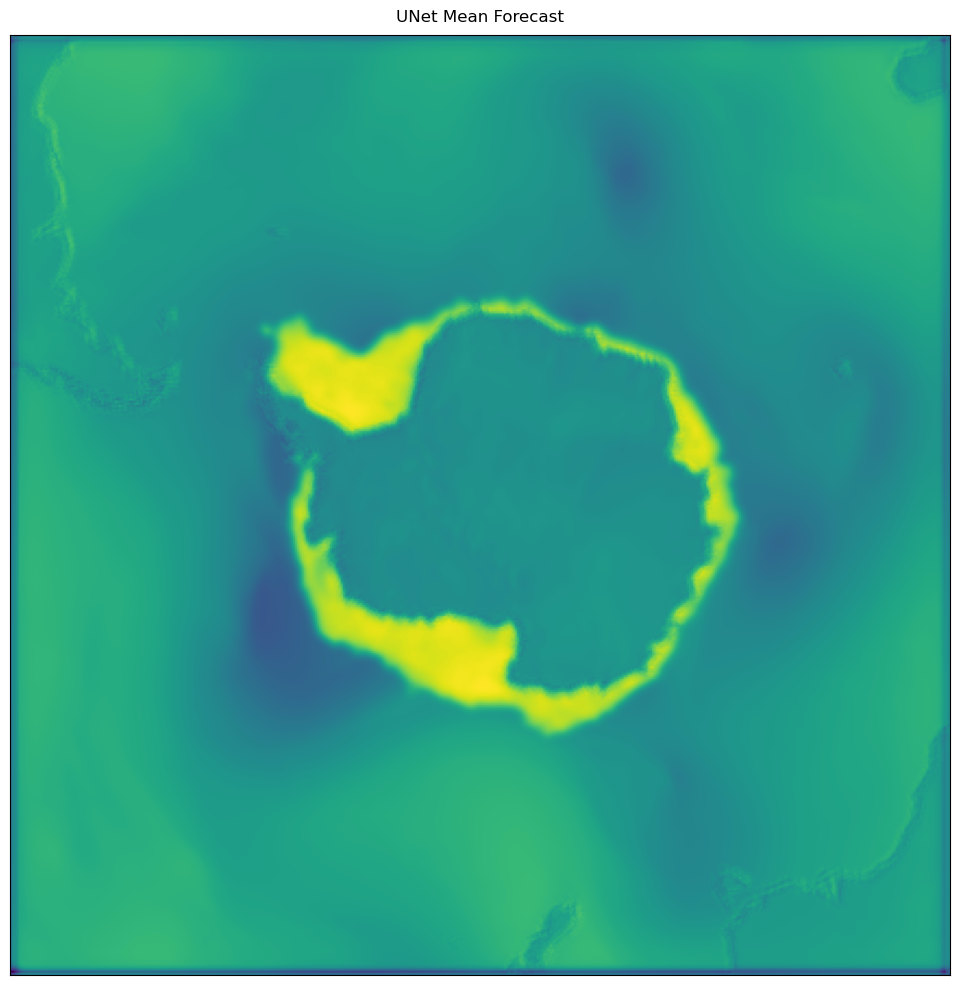

In [33]:
import matplotlib.pyplot as plt
fig = plt.figure(figsize=(18, 10))

plt.imshow(prediction[0, :, :, 0, 0])
plt.xticks([])
plt.yticks([])

plt.suptitle("UNet Mean Forecast")
plt.tight_layout()
plt.show()

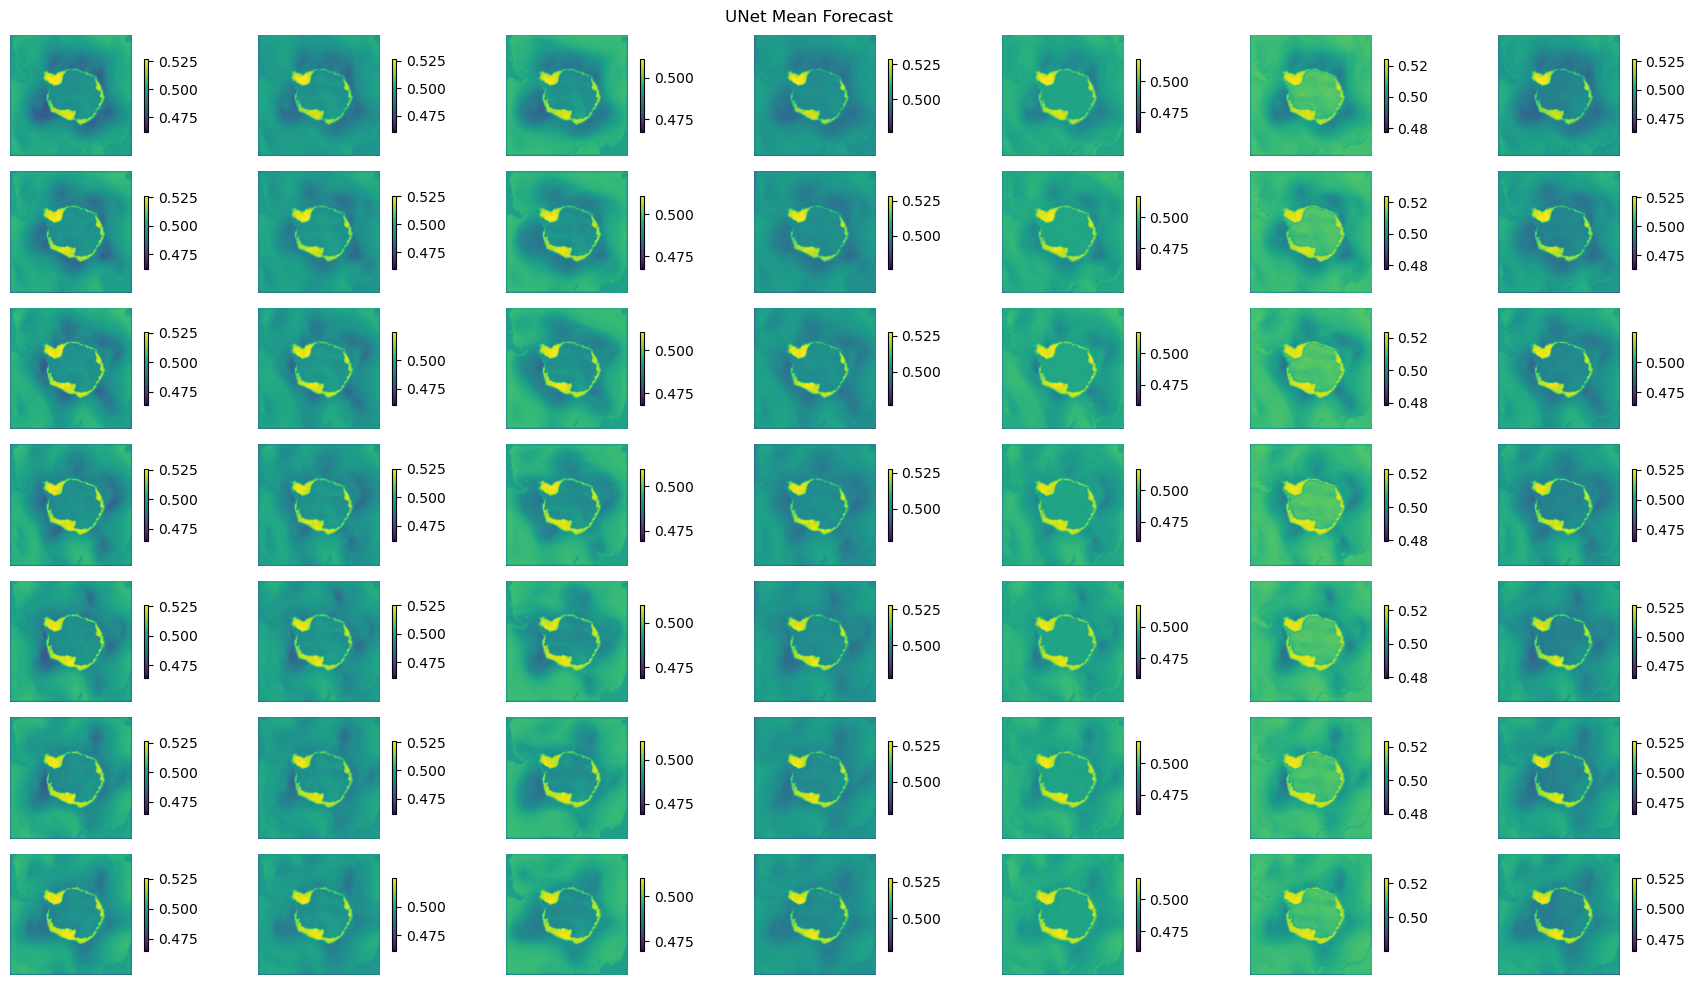

In [34]:
import matplotlib.pyplot as plt

fig, ax = plt.subplots(7, 7, figsize=(18, 10))
ax = ax.ravel()

idx = 0
for workers, prediction in enumerate(predictions):
    for batch in range(prediction.shape[0]):
        # print(idx, worker, batch, prediction.shape, prediction[0, :, :, :, 0].shape)
        for day in range(prediction.shape[-1]): # Loop through no. of forecast days (currently 7)
            im = ax[idx].imshow(prediction[batch, :, :, 0, day], extent=[0, 1, 0, 1])
            ax[idx].axis("off")
            plt.colorbar(im, ax=ax[idx], shrink=0.6)
            idx += 1


plt.suptitle("UNet Mean Forecast")
plt.subplots_adjust(wspace=0, hspace=0)
plt.margins(0)
plt.tight_layout()
plt.show()